# Importação de bibliotecas e criação de funções auxiliares

In [17]:
import numpy as np # Biblioteca para manipulação de matrizes
import pandas as pd # Biblioteca para manipulação de datasets
import statistics as stats # Biblioteca para aplicação de funções estatísticas
from scipy import stats as stats2 # Biblioteca para aplicação de funções estatísticas
import cv2 # Biblioteca para visão computacional
import os # Biblioteca do Sistema Operacional
import matplotlib.pyplot as plt # Biblioteca pra visualização de dados
import seaborn as sns # Biblioteca pra visualização de dados
from sklearn.metrics import auc # Biblioteca para cálculo de área sobre a curva (utilizada na função get_features)
% matplotlib inline

import time # Bibliteca para cálculo de tempo
start_time = time.time()

In [18]:
def get_int(val):

  ### Função de arredondamento para Theta ###

  ''' Esta função foi criada, como mostra na etapa de introdução, para realizar um ajuste nos pontos de contorno de cada imagem,
      multiplicando eles por 10⁶ para realizar um arredondamento e ordenalos de maneira correta, fazendo com que o DataFrame que
      que utilizará estes valores para ordenar os valores de Theta'''

  Value = val*10**6
  Inteiro = round(Value)
  return Inteiro

In [19]:

img_folder_path  = '/content/drive/My Drive/Colab Notebooks/TCC/HAM10000/HAM10000/color_image/'
mask_folder_path = '/content/drive/My Drive/Colab Notebooks/TCC/HAM10000/HAM10000/segmentations_lesion/'
img_extension = '.jpg'
mask_extension = '_segmentation.png'

def get_features(img):

  ### Função responsável por retirar as características da imagem ###

  ''' Função responsável por retirar todas as informações pertinentes sobre a imagem, analisando desde a coloração na região de
      importância, até características geométricas como raio, assimetria e borda. Cada etapa do código é explicada a seguir.

  '''

  ## Carregando a imagem e sua máscara e realizando as transformações de cores ##
  path = img_folder_path + img
  img_BGR = cv2.imread(path + img_extension)
  img_RGB = cv2.cvtColor(img_BGR,cv2.COLOR_BGR2RGB)
  img_gray = cv2.cvtColor(img_BGR,cv2.COLOR_BGR2GRAY)
  mask_bin = cv2.imread(mask_folder_path + img + mask_extension,0)

  ## Configurando especificações de altura e largura da imagem  ##
  shape = img_BGR.shape
  alt  = shape[0]
  larg = shape[1]
  h = alt
  w = larg

  ## Criação de imagens auxiliares para criação do contorno e da menor elipse  ##
  black1 = np.zeros((alt,larg,3),np.uint8)
  black2 = black1.copy()


  ## Binarização da imagem e cálculo dos momentos da imagem ##
  kernel = np.ones((30,30),dtype=np.uint8)
  transf = cv2.morphologyEx(mask_bin,cv2.MORPH_CLOSE,kernel)
  ret, th1 = cv2.threshold(transf,127,255,0)
  contours,hierarchy = cv2.findContours(th1, 1, 2)
  cnt = contours[0]
  M = cv2.moments(cnt)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  
  ## Criação do contorno e da menor elipse utilizando os valores do contorno ##
  contorno = cv2.drawContours(black1, contours, -1, (0,255,255), 1)

  
  #corners = cv2.goodFeaturesToTrack(th1,0,0.01,10)

  if len(cnt) < 5:
    ellipse_stats = ((cx, cy), (100, 100), 0.0)
    #ellipse_stats = cv2.fitEllipse(cnt2)
  else:
    ellipse_stats = cv2.fitEllipse(cnt)
  
  ellipse = cv2.ellipse(black2,ellipse_stats,(255,255,255),-1)
  ellipse = cv2.cvtColor(ellipse,cv2.COLOR_BGR2GRAY)
  ret, th2 = cv2.threshold(ellipse,127,255,0)
  contours, hierarchy = cv2.findContours(th2, 1, 2)
  ellipse = cv2.drawContours(black2, contours, -1, (0,255,255), 0)




  ### Preparação de variáveis de armazenamento para análise ###

  # Variáveis para COR #
  R = []
  B = []
  G = []
  Gray = []

  # Variáveis para ASSIMETRIA #
  sumq1, sumq2, sumq3, sumq4 = 0,0,0,0

  # Variáveis para armazenar os PONTOS pertencentes as bordas do contorno e da elipse #
  PQ1xCont, PQ1yCont = [], []
  PQ2xCont, PQ2yCont = [], []
  PQ3xCont, PQ3yCont = [], []
  PQ4xCont, PQ4yCont = [], []
  PQ1xElip, PQ1yElip = [], []
  PQ2xElip, PQ2yElip = [], []
  PQ3xElip, PQ3yElip = [], []
  PQ4xElip, PQ4yElip = [], []
  

  ## Varredura de toda imagem, buscando os valores pertinentes ##
  for i in range(0,alt):
    for j in range(0,larg):
      if th1[i,j] > 0:
        R.append(img_RGB[i,j,0])
        B.append(img_RGB[i,j,1])
        G.append(img_RGB[i,j,2])
        Gray.append(img_gray[i,j])

        if j < cx:
          if i < cy:
            # Primeiro Quadrante
            sumq1 += 1
          else:
            # Terceiro Quadrante
            sumq3 += 1
        else:
          if i < cy:
            # Segundo Quadrante
            sumq2 += 1 
          else: 
            # Quarto Quadrante
            sumq4 += 1

      if contorno[i,j,1] > 0:
        if j < cx:
          if i < cy:
            # Segundo Quadrante
            PQ2xCont.append(j)
            PQ2yCont.append(i)
          
          else:
             # Terceiro Quadrante
             PQ3xCont.append(j)
             PQ3yCont.append(i)

        else:
          if i < cy:
             # Primeiro Quadrante
             PQ1xCont.append(j)
             PQ1yCont.append(i)

          else:
            # Quarto Quadrante
            PQ4xCont.append(j)
            PQ4yCont.append(i)
            
      if ellipse[i,j,1] > 0:
        if j < cx:
          if i < cy:
            # Segundo Quadrante
            PQ2xElip.append(j)
            PQ2yElip.append(i)
          
          else:
             # Terceiro Quadrante
             PQ3xElip.append(j)
             PQ3yElip.append(i)

        else:
          if i < cy:
             # Primeiro Quadrante
             PQ1xElip.append(j)
             PQ1yElip.append(i)

          else:
            # Quarto Quadrante
            PQ4xElip.append(j)
            PQ4yElip.append(i)  


  ## Conversão de lista em vetor para realizar os cálculos ##
  ## Conversão de lista em vetor para realizar os cálculos ##
  R = pd.Series(R)
  G = pd.Series(G)
  B = pd.Series(B)
  Gray = pd.Series(Gray)

  Rmed = R.mean()
  Rvar = R.var()
  Rstd = R.std()
  Rmax = R.max()
  Rmin = R.min()
  Rmdn = R.median()
  RQ25 = R.quantile(q=0.25)
  RQ75 = R.quantile(q=0.75)
  Rmod = R.mode()[0]
  Ramp = Rmax - Rmin
  Rsta = R.mad()
  Rgeo = stats2.gmean(R)
  Rhar = stats2.hmean(R)

  Gmed = G.mean()
  Gvar = G.var()
  Gstd = G.std()
  Gmax = G.max()
  Gmin = G.min()
  Gmdn = G.median()
  GQ25 = G.quantile(q=0.25)
  GQ75 = G.quantile(q=0.75)
  Gmod = G.mode()[0]
  Gamp = Gmax - Gmin
  Gsta = G.mad()
  Ggeo = stats2.gmean(G)
  Ghar = stats2.hmean(G)


  Bmed = B.mean()
  Bvar = B.var()
  Bstd = B.std()
  Bmax = B.max()
  Bmin = B.min()
  Bmdn = B.median()
  BQ25 = B.quantile(q=0.25)
  BQ75 = B.quantile(q=0.75)
  Bmod = B.mode()[0]
  Bamp = Bmax - Bmin
  Bsta = B.mad()
  Bgeo = stats2.gmean(B)
  Bhar = stats2.hmean(B)

  Graymed = Gray.mean()
  Grayvar = Gray.var()
  Graystd = Gray.std()
  Graymax = Gray.max()
  Graymin = Gray.min()
  Graymdn = Gray.median()
  GrayQ25 = Gray.quantile(q=0.25)
  GrayQ75 = Gray.quantile(q=0.75)
  Graymod = Gray.mode()[0]
  Grayamp = Graymax - Graymin
  Graysta = Gray.mad()
  Graygeo = stats2.gmean(Gray)
  Grayhar = stats2.hmean(Gray)


  ## Obtenção do raio, perímetro e área através dos momentos calculados ##
  (x,y),radius = cv2.minEnclosingCircle(cnt)
  raio = int(radius)
  area = cv2.contourArea(cnt)
  perimetro = cv2.arcLength(cnt,True)


  ## Cálculo de assimetria em X e em Y ## ------------
  assymx = np.absolute(sumq1+sumq3 - (sumq2+sumq4)) #|
  assymy = np.absolute(sumq1+sumq2 - (sumq3+sumq4)) #|
                                                   
  ## Conversão de lista para vetor dos pontos percetences a elipse e contorno  ##
  PQ1xCont = np.asarray(PQ1xCont)
  PQ1yCont = np.asarray(PQ1yCont)
  PQ2xCont = np.asarray(PQ2xCont)
  PQ2yCont = np.asarray(PQ2yCont)
  PQ3xCont = np.asarray(PQ3xCont)
  PQ3yCont = np.asarray(PQ3yCont)
  PQ4xCont = np.asarray(PQ4xCont)
  PQ4yCont = np.asarray(PQ4yCont)


  PQ1xElip = np.asarray(PQ1xElip)
  PQ1yElip = np.asarray(PQ1yElip)
  PQ2xElip = np.asarray(PQ2xElip)
  PQ2yElip = np.asarray(PQ2yElip)
  PQ3xElip = np.asarray(PQ3xElip)
  PQ3yElip = np.asarray(PQ3yElip)
  PQ4xElip = np.asarray(PQ4xElip)
  PQ4yElip = np.asarray(PQ4yElip)


  PxCont = np.concatenate([PQ1xCont,PQ2xCont,PQ3xCont,PQ4xCont])
  PyCont = np.concatenate([PQ1yCont,PQ2yCont,PQ3yCont,PQ4yCont])

  PxElip = np.concatenate([PQ1xElip,PQ2xElip,PQ3xElip,PQ4xElip])
  PyElip = np.concatenate([PQ1yElip,PQ2yElip,PQ3yElip,PQ4yElip])

  ## Translação dos pontos para a origem e rotação da imagem ##
  PX_cont = PxCont-cx
  PY_cont = -PyCont+cy

  PX_elip = PxElip-cx
  PY_elip = -PyElip+cy

  ## Cálculo da distância do centro até a borda e de theta ##
  R_cont = np.sqrt(PX_cont**2+PY_cont**2)

  Theta_cont = []

  for i in range(0,len(R_cont)):
    cos = PX_cont[i]/R_cont[i]
    if cos > 1:
      cos = 1
    if cos < -1:
      cos = -1
    else:
      cos = cos
    Theta = np.degrees(np.arccos(cos))
    Theta_cont.append(Theta)

  Theta_cont = np.asarray(Theta_cont)

  R_elip = np.sqrt(PX_elip**2+PY_elip**2)

  Theta_elip = []

  for i in range(0,len(R_elip)):
    cos = PX_elip[i]/R_elip[i]
    if cos > 1:
      cos = 1
    if cos < -1:
      cos = -1
    else:
      cos = cos
    Theta = np.degrees(np.arccos(cos))
    Theta_elip.append(Theta)

  Theta_elip = np.asarray(Theta_elip)

  ## Ajuste dos valores de Theta calculado 0-180 para 0-360 ##
  Theta180Elip, Theta360Elip = [], []
  R180Elip, R360Elip = [], []
  Theta180Cont, Theta360Cont = [], []
  R180Cont, R360Cont = [], []

  for i in range(0,round(len(Theta_cont)/2)+2):
    Theta180Cont.append(Theta_cont[i])
    R180Cont.append(R_cont[i])

  for i in range(round(len(Theta_cont)/2)-1,len(Theta_cont)):
     Theta360Cont.append(Theta_cont[i])
     R360Cont.append(R_cont[i])
     
  Theta180Cont = np.asarray(Theta180Cont)
  Theta360Cont = np.asarray(Theta360Cont)
  R180Cont = np.asarray(R180Cont)
  R360Cont = np.asarray(R360Cont)

  Theta180_cont = -np.asarray(Theta180Cont)+360
  Theta360_cont = np.asarray(Theta360Cont)
  R180_cont = np.asarray(R180Cont)
  R360_cont =np.asarray(R360Cont)
  Theta_cont_final = np.concatenate([Theta180_cont,Theta360_cont])
  R_cont_final = np.concatenate([R180_cont,R360_cont])


  for i in range(0,round(len(Theta_elip)/2)):
    Theta180Elip.append(Theta_elip[i])
    R180Elip.append(R_elip[i])

  for i in range(round(len(Theta_elip)/2),len(Theta_elip)):
    Theta360Elip.append(Theta_elip[i])
    R360Elip.append(R_elip[i])

  Theta180_elip = -np.asarray(Theta180Elip)+360
  Theta360_elip = np.asarray(Theta360Elip)
  R180_elip = np.asarray(R180Elip)
  R360_elip =np.asarray(R360Elip)
  Theta_elip_final = np.concatenate([Theta180_elip,Theta360_elip])
  R_elip_final = np.concatenate([R180_elip, R360_elip])

  
  ## Ordenação dos valores de Theta ##
  Theta = pd.DataFrame(Theta_cont_final, columns = ['Theta'])
  R = pd.DataFrame(R_cont_final, columns = ['Raio'])
  Total = pd.concat([Theta, R], axis=1)
  Total = Total.fillna(method = 'backfill',axis = 1)
  Tec = Total['Theta'].apply(lambda x : get_int(x))
  Tec = pd.DataFrame(Tec, columns = ['Theta'])
  Total = pd.concat([Tec,R], axis=1)
  Total_cont = Total.sort_values(by=['Theta'])
  Total_cont['Theta'] = Total_cont['Theta']*10**-6
  
  Theta = pd.DataFrame(Theta_elip_final, columns = ['Theta'])
  R = pd.DataFrame(R_elip_final, columns = ['Raio'])
  Total = pd.concat([Theta, R], axis=1)
  Total = Total.fillna(method = 'backfill',axis = 1)
  Tec = Total['Theta'].apply(lambda x : get_int(x))
  Tec = pd.DataFrame(Tec, columns = ['Theta'])
  Total = pd.concat([Tec,R], axis=1)
  Total_elip = Total.sort_values(by=['Theta'])
  Total_elip['Theta'] = Total_elip['Theta']*10**-6

  ## Cálculo das diferença entre as áreas dos dois gráficos ##
  X = Total_elip['Theta']
  Y = Total_elip['Raio']
  Area_elip = auc(X,Y)
  X = Total_cont['Theta']
  Y = Total_cont['Raio']
  Area_cont = auc(X,Y)
  Dif_area = abs(Area_cont - Area_elip)

  AmpSup = abs(Total_elip['Raio'].max() - Total_cont['Raio'].max())
  AmpInf = abs(Total_elip['Raio'].min() - Total_cont['Raio'].min())


  ## Cálculo de amplitude absoluta ##
  Max_raio_cont = Total_cont['Raio'].max()
  Min_raio_cont = Total_cont['Raio'].min()
  Raio_cont_med = Total_cont['Raio'].mean()
  Raio_cont_mdn = Total_cont['Raio'].median()
  Raio_cont_Q25 = Total_cont['Raio'].quantile(q=0.25)
  Raio_cont_Q75 = Total_cont['Raio'].quantile(q=0.75)
  Raio_cont_mod = Total_cont['Raio'].mode()[0]
  Raio_cont_sta = Total_cont['Raio'].mad()
  Raio_cont_geo = stats2.gmean(Total_cont['Raio'])
  Raio_cont_har = stats2.hmean(Total_cont['Raio'])
  Amp_cont = Max_raio_cont - Min_raio_cont
  Amp_cont_abs = Amp_cont/Max_raio_cont

  print('-------------------')
  print(img)
  final_time = time.time() - start_time
  print(final_time/60)
  print('-------------------')

  return Rmed, Rvar, Rstd, Gmed, Gvar, Gstd, Bmed, Bvar, Bstd, Graymed, Grayvar, Graystd, raio, area, perimetro, assymx, assymy, Dif_area, Amp_cont_abs, Rmax,Rmin, Rmdn, RQ25, RQ75, Rmod, Ramp, Rsta, Rgeo, Rhar, Gmax, Gmin, Gmdn, GQ25, GQ75, Gmod, Gamp, Gsta, Ggeo, Ghar, Bmax, Bmin, Bmdn, BQ25, BQ75, Bmod, Bamp, Bsta, Bgeo, Bhar, Graymax, Graymin, Graymdn, GrayQ25, GrayQ75, Graymod, Grayamp, Graysta, Graygeo, Grayhar, Amp_cont, Max_raio_cont, Min_raio_cont, Raio_cont_med, Raio_cont_mdn, Raio_cont_Q25, Raio_cont_Q75, Raio_cont_mod, Raio_cont_sta, Raio_cont_geo, Raio_cont_har, AmpSup, AmpInf

# Manipulação do Dataset e ajuste para retirada de características

In [20]:
doc_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TCC/HAM10000/HAM10000/HAM10000_metadata.csv')
doc_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [21]:
img_file = cv2.imread(img_folder_path + 'ISIC_0027419' + img_extension)
mask_file = cv2.imread(mask_folder_path + 'ISIC_0027419' + mask_extension)

(450, 600, 3)
(450, 600, 3)


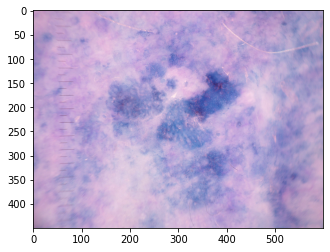

In [22]:
print(img_file.shape)
print(mask_file.shape)
plt.imshow(img_file)

In [7]:
doc_data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [8]:
doc_data['age'] = doc_data['age'].fillna(doc_data['age'].mean())

In [9]:
doc_data.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [10]:
# Agora que a planilha foi padronizada e configurada em valores binários, vamos dividir em características de teste e resultado
result = doc_data[['dx', 'dx_type']]
doc_data = doc_data.drop(['dx', 'dx_type'],axis=1)

In [11]:
full_doc_data = pd.concat([doc_data, result], axis=1, join='inner')
full_doc_data

,lesion_id,image_id,age,sex,localization,dx,dx_type
0,HAM_0000118,ISIC_0027419,80.0,male,scalp,bkl,histo
1,HAM_0000118,ISIC_0025030,80.0,male,scalp,bkl,histo
2,HAM_0002730,ISIC_0026769,80.0,male,scalp,bkl,histo
3,HAM_0002730,ISIC_0025661,80.0,male,scalp,bkl,histo
4,HAM_0001466,ISIC_0031633,75.0,male,ear,bkl,histo
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,40.0,male,abdomen,akiec,histo
10011,HAM_0002867,ISIC_0033550,40.0,male,abdomen,akiec,histo
10012,HAM_0002867,ISIC_0033536,40.0,male,abdomen,akiec,histo
10013,HAM_0000239,ISIC_0032854,80.0,male,face,akiec,histo


In [12]:
# Agora, vamos criar um DataFrame, utilizando somente as imagens e dados coletados dela
img_data = pd.DataFrame()
img_data['lesion_id'] = doc_data['lesion_id']
img_data['img_id'] = doc_data['image_id']
img_data.head()

,lesion_id,img_id
0,HAM_0000118,ISIC_0027419
1,HAM_0000118,ISIC_0025030
2,HAM_0002730,ISIC_0026769
3,HAM_0002730,ISIC_0025661
4,HAM_0001466,ISIC_0031633


In [13]:
img_data.shape

(10015, 2)

In [14]:
#img_data = img_data.head(6000)
img_data

,lesion_id,img_id
0,HAM_0000118,ISIC_0027419
1,HAM_0000118,ISIC_0025030
2,HAM_0002730,ISIC_0026769
3,HAM_0002730,ISIC_0025661
4,HAM_0001466,ISIC_0031633
...,...,...
10010,HAM_0002867,ISIC_0033084
10011,HAM_0002867,ISIC_0033550
10012,HAM_0002867,ISIC_0033536
10013,HAM_0000239,ISIC_0032854


In [15]:
teste = cv2.imread(img_folder_path +'ISIC_0033084.jpg')
teste.shape

(450, 600, 3)

In [16]:
all_features = img_data['img_id'].apply(lambda x : get_features(x))

-------------------
ISIC_0027419
0.12146901289621989
-------------------
-------------------
ISIC_0025030
0.16208507617314658
-------------------
-------------------
ISIC_0026769
0.20902002255121868
-------------------
-------------------
ISIC_0025661
0.2444067120552063
-------------------
-------------------
ISIC_0031633
0.29812177817026775
-------------------
-------------------
ISIC_0027850
0.3387057065963745
-------------------
-------------------
ISIC_0029176
0.39495709737141926
-------------------
-------------------
ISIC_0029068
0.43339717785517373
-------------------
-------------------
ISIC_0025837
0.484076992670695
-------------------
-------------------
ISIC_0025209
0.5324242154757182
-------------------
-------------------
ISIC_0025276
0.5799202640851339
-------------------
-------------------
ISIC_0029396
0.6152491927146911
-------------------
-------------------
ISIC_0025984
0.6472420771916707
-------------------
-------------------
ISIC_0025767
0.6866787195205688
-------

KeyboardInterrupt: ignored

In [ ]:
all_features = np.asarray(all_features)

In [ ]:
Rmed, Rvar, Rstd = [],[],[]
Gmed, Gvar, Gstd = [],[],[]
Bmed, Bvar, Bstd = [],[],[]
Graymed, Grayvar, Graystd = [],[],[]
raio, area, perimetro = [],[],[]
Rmax, Rmin, Rmdn, RQ25, RQ75, Rmod, Ramp, Rsta, Rgeo, Rhar = [],[],[],[],[],[],[],[],[],[]
Gmax, Gmin, Gmdn, GQ25, GQ75, Gmod, Gamp, Gsta, Ggeo, Ghar = [],[],[],[],[],[],[],[],[],[]
Bmax, Bmin, Bmdn, BQ25, BQ75, Bmod, Bamp, Bsta, Bgeo, Bhar = [],[],[],[],[],[],[],[],[],[]
Graymax, Graymin, Graymdn, GrayQ25, GrayQ75, Graymod, Grayamp, Graysta, Graygeo, Grayhar = [],[],[],[],[],[],[],[],[],[]
Raioamp, Raiomax, Raiomin, Raiomed, Raiomdn, RaioQ25, RaioQ75, Raiomod, Raiosta, Raiogeo, Raiohar = [],[],[],[],[],[],[],[],[],[],[]
assymx, assymy, Dif_area, Amp_cont_abs = [],[],[],[]
AmpSup, AmpInf =[],[]

for i,col in enumerate(all_features):
  Rmed.append(all_features[i][0])
  Rvar.append(all_features[i][1])
  Rstd.append(all_features[i][2])
  Gmed.append(all_features[i][3])
  Gvar.append(all_features[i][4])
  Gstd.append(all_features[i][5])
  Bmed.append(all_features[i][6])
  Bvar.append(all_features[i][7])
  Bstd.append(all_features[i][8])
  Graymed.append(all_features[i][9])
  Grayvar.append(all_features[i][10])
  Graystd.append(all_features[i][11])
  raio.append(all_features[i][12])
  area.append(all_features[i][13])
  perimetro.append(all_features[i][14])
  assymx.append(all_features[i][15])
  assymy.append(all_features[i][16])
  Dif_area.append(all_features[i][17])
  Amp_cont_abs.append(all_features[i][18])
  Rmax.append(all_features[i][19])
  Rmin.append(all_features[i][20])
  Rmdn.append(all_features[i][21])
  RQ25.append(all_features[i][22])
  RQ75.append(all_features[i][23])
  Rmod.append(all_features[i][24])
  Ramp.append(all_features[i][25])
  Rsta.append(all_features[i][26])
  Rgeo.append(all_features[i][27])
  Rhar.append(all_features[i][28])
  Gmax.append(all_features[i][29])
  Gmin.append(all_features[i][30])
  Gmdn.append(all_features[i][31])
  GQ25.append(all_features[i][32])
  GQ75.append(all_features[i][33])
  Gmod.append(all_features[i][34])
  Gamp.append(all_features[i][35])
  Gsta.append(all_features[i][36])
  Ggeo.append(all_features[i][37])
  Ghar.append(all_features[i][38])
  Bmax.append(all_features[i][39])
  Bmin.append(all_features[i][40])
  Bmdn.append(all_features[i][41])
  BQ25.append(all_features[i][42])
  BQ75.append(all_features[i][43])
  Bmod.append(all_features[i][44])
  Bamp.append(all_features[i][45])
  Bsta.append(all_features[i][46])
  Bgeo.append(all_features[i][47])
  Bhar.append(all_features[i][48])
  Graymax.append(all_features[i][49])
  Graymin.append(all_features[i][50])
  Graymdn.append(all_features[i][51])
  GrayQ25.append(all_features[i][52])
  GrayQ75.append(all_features[i][53])
  Graymod.append(all_features[i][54])
  Grayamp.append(all_features[i][55])
  Graysta.append(all_features[i][56])
  Graygeo.append(all_features[i][57])
  Grayhar.append(all_features[i][58])
  Raioamp.append(all_features[i][59])
  Raiomax.append(all_features[i][60])
  Raiomin.append(all_features[i][61])
  Raiomed.append(all_features[i][62])
  Raiomdn.append(all_features[i][63])
  RaioQ25.append(all_features[i][64])
  RaioQ75.append(all_features[i][65])
  Raiomod.append(all_features[i][66])
  Raiosta.append(all_features[i][67])
  Raiogeo.append(all_features[i][68])
  Raiohar.append(all_features[i][69])
  AmpSup.append(all_features[i][70])
  AmpInf.append(all_features[i][71])

Rmed = np.asarray(Rmed)
Rvar = np.asarray(Rvar)
Rstd = np.asarray(Rstd)
Gmed = np.asarray(Gmed)
Gvar = np.asarray(Gvar)
Gstd = np.asarray(Gstd)
Bmed = np.asarray(Bmed)
Bvar = np.asarray(Bvar)
Bstd = np.asarray(Bstd)
Graymed = np.asarray(Graymed)
Grayvar = np.asarray(Grayvar)
Graystd = np.asarray(Graystd)
raio = np.asarray(raio)
area = np.asarray(area)
perimetro = np.asarray(perimetro)
assymx = np.asarray(assymx)
assymy = np.asarray(assymy)
Dif_area = np.asarray(Dif_area)
Amp_cont_abs = np.asarray(Amp_cont_abs)
Rmax = np.asarray(Rmax)
Rmin = np.asarray(Rmin)
Rmdn = np.asarray(Rmdn)
RQ25 = np.asarray(RQ25)
RQ75 = np.asarray(RQ75)
Rmod = np.asarray(Rmod)
Ramp = np.asarray(Ramp)
Rsta = np.asarray(Rsta)
Rgeo = np.asarray(Rgeo)
Rhar = np.asarray(Rhar)
Gmax = np.asarray(Gmax)
Gmin = np.asarray(Gmin)
Gmdn = np.asarray(Gmdn)
GQ25 = np.asarray(GQ25)
GQ75 = np.asarray(GQ75)
Gmod = np.asarray(Gmod)
Gamp = np.asarray(Gamp)
Gsta = np.asarray(Gsta)
Ggeo = np.asarray(Ggeo)
Ghar = np.asarray(Ghar)
Bmax = np.asarray(Bmax)
Bmin = np.asarray(Bmin)
Bmdn = np.asarray(Bmdn)
BQ25 = np.asarray(BQ25)
BQ75 = np.asarray(BQ75)
Bmod = np.asarray(Bmod)
Bamp = np.asarray(Bamp)
Bsta = np.asarray(Bsta)
Bgeo = np.asarray(Bgeo)
Bhar = np.asarray(Bhar)
Graymax = np.asarray(Graymax)
Graymin = np.asarray(Graymin)
Graymdn = np.asarray(Graymdn)
GrayQ25 = np.asarray(GrayQ25)
GrayQ75 = np.asarray(GrayQ75)
Graymod = np.asarray(Graymod)
Grayamp = np.asarray(Grayamp)
Graysta = np.asarray(Graysta)
Graygeo = np.asarray(Graygeo)
Grayhar = np.asarray(Grayhar)
Graymax = np.asarray(Graymax)
Graymin = np.asarray(Graymin)
Graymdn = np.asarray(Graymdn)
GrayQ25 = np.asarray(GrayQ25)
GrayQ75 = np.asarray(GrayQ75)
Graymod = np.asarray(Graymod)
Grayamp = np.asarray(Grayamp)
Graysta = np.asarray(Graysta)
Graygeo = np.asarray(Graygeo)
Grayhar = np.asarray(Grayhar)
Raioamp = np.asarray(Raioamp)
Raiomax = np.asarray(Raiomax)
Raiomin = np.asarray(Raiomin)
Raiomed = np.asarray(Raiomed)
Raiomdn = np.asarray(Raiomdn)
RaioQ25 = np.asarray(RaioQ25)
RaioQ75 = np.asarray(RaioQ75)
Raiomod = np.asarray(Raiomod)
Raiosta = np.asarray(Raiosta)
Raiogeo = np.asarray(Raiogeo)
Raiohar = np.asarray(Raiohar)
AmpSup  = np.asarray(AmpSup)
AmpInf  = np.asarray(AmpInf)



img_data['media_red'] = Rmed
img_data['media_green'] = Gmed
img_data['media_blue'] = Bmed
img_data['var_red'] = Rvar
img_data['var_green'] = Gvar
img_data['var_blue'] = Bvar
img_data['desvio_red'] = Rstd
img_data['desvio_green'] = Gstd
img_data['desvio_blue'] = Bstd
img_data['media_gray'] = Graymed
img_data['var_gray'] = Grayvar
img_data['desvio_gray'] = Graystd
img_data['raio'] = raio
img_data['area'] = area
img_data['perimetro'] = perimetro
img_data['asymetriX'] = assymx
img_data['asymetriY'] = assymy
img_data['difarea'] = Dif_area
img_data['ampabs'] = Amp_cont_abs
img_data['Rmax'] = Rmax
img_data['Rmin'] = Rmin
img_data['Rmdn'] = Rmdn
img_data['RQ25'] = RQ25  
img_data['RQ75'] = RQ75
img_data['Rmod'] = Rmod
img_data['Ramp'] = Ramp
img_data['Rsta'] = Rsta
img_data['Rgeo'] = Rgeo
img_data['Rhar'] = Rhar
img_data['Gmax'] = Gmax
img_data['Gmin'] = Gmin
img_data['Gmdn'] = Gmdn
img_data['GQ25'] = GQ25
img_data['GQ75'] = GQ75
img_data['Gmod'] = Gmod
img_data['Gamp'] = Gamp
img_data['Gsta'] = Gsta
img_data['Ggeo'] = Ggeo
img_data['Ghar'] = Ghar
img_data['Bmax'] = Bmax
img_data['Bmin'] = Bmin
img_data['Bmdn'] = Bmdn
img_data['BQ25'] = BQ25
img_data['BQ75'] = BQ75
img_data['Bmod'] = Bmod
img_data['Bamp'] = Bamp
img_data['Bsta'] = Bsta
img_data['Bgeo'] = Bgeo
img_data['Bhar'] = Bhar 
img_data['Graymax'] = Graymax
img_data['Graymin'] = Graymin
img_data['Graymdn'] = Graymdn
img_data['GrayQ25'] = GrayQ25
img_data['GrayQ75'] = GrayQ75
img_data['Graymod'] = Graymod
img_data['Grayamp'] = Grayamp
img_data['Graysta'] = Graysta
img_data['Graygeo'] = Graygeo
img_data['Grayhar'] = Grayhar
img_data['Graymax'] = Graymax
img_data['Raioamp'] = Raioamp
img_data['Raiomax'] = Raiomax
img_data['Raiomin'] = Raiomin
img_data['Raiomed'] = Raiomed
img_data['Raiomdn'] = Raiomdn
img_data['RaioQ25'] = RaioQ25
img_data['RaioQ75'] = RaioQ75
img_data['Raiomed'] = Raiomod
img_data['Raiosta'] = Raiosta
img_data['Raiogeo'] = Raiogeo
img_data['Raiohar'] = Raiohar
img_data['AmpSup']  = AmpSup
img_data['AmpInf']  = AmpInf


In [ ]:
img_data.head()

In [ ]:
full_img_data = pd.concat([img_data, result], axis=1, join='inner')
full_img_data

In [ ]:
full_all_data = pd.concat([doc_data,img_data.drop(['lesion_id','img_id'],axis=1), result], axis=1, join='inner')
full_all_data

In [ ]:
full_img_data.to_csv("Dados_Imagem.csv")
full_doc_data.to_csv('Dados_Doc.csv')
full_all_data.to_csv('Full_Data.csv')

In [ ]:
final_time = time.time() - start_time
final_time

In [ ]:
final_time/60

In [ ]:
tempo_sample10 = 51.48855185508728
tempo_sample10